## Training with Pre-trained models
Authors:
- Mario Izquierdo
- Martín Romero

In this notebook we are going to experiment with pre-trained models to solve the proposed image classification problem. Specifically in this notebook we are going to experiment with the InceptionV3 pretrained network. The way the model will be trained will be using fine-tuning, that consists of unfreezing a few of the top layers of a frozen model base used for feature extraction.

In [1]:
import keras
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import csv
import tensorflow as tf
import matplotlib.pyplot as plt

2024-03-05 20:38:03.341583: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 20:38:03.405777: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 20:38:03.405818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 20:38:03.407042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 20:38:03.428275: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.config.set_visible_devices([], 'GPU')

2024-03-05 20:38:06.847438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 20:38:06.891223: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 20:38:06.891607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Load dataset

We load the images from our dataset to create the train, validation and test sets. In this case we have used an image size of (180,180) due to the limited computational capacity of our computer.

In [3]:
img_size = 180
image_size = (img_size, img_size)
img_tensor_shape = (img_size, img_size, 3)
batch_size = 32
train_dataset = image_dataset_from_directory(
    '../data/new_data/train',
    image_size = image_size,
    batch_size = batch_size)
test_dataset = image_dataset_from_directory(
    '../data/new_data/test',
    image_size = image_size,
    batch_size=batch_size)
val_dataset = image_dataset_from_directory(
    '../data/new_data/validation',
    image_size = image_size,
    batch_size=batch_size)

Found 10778 files belonging to 5 classes.
Found 1497 files belonging to 5 classes.
Found 2696 files belonging to 5 classes.


## Using InceptionV3 model

In [4]:
conv_base = keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

### Unfreezing a few top layers

In [5]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

### Creating the model
We added to the pretrained model, a final layer with Dropout, to adapt the network to our problem

In [6]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.inception_v3.preprocess_input(inputs) 
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

#### Fitting the model

In [7]:
# Fine-tuning the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
  
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/fine_tuning_InceptionV3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20, 
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/20


2024-03-05 20:38:21.504089: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4248002750 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-03-05 20:38:21.504135: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-03-05 20:38:21.953963: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709667508.256306    5111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-05 20:38:28.270964: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


337/337 ━━━━━━━━━━━━━━━━━━━━ 916s 3s/step - accuracy: 0.8220 - loss: 0.8241 - val_accuracy: 0.9559 - val_loss: 0.1841
Epoch 2/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 671s 2s/step - accuracy: 0.9514 - loss: 0.2101 - val_accuracy: 0.9525 - val_loss: 0.2113
Epoch 3/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 593s 2s/step - accuracy: 0.9644 - loss: 0.1410 - val_accuracy: 0.9618 - val_loss: 0.1785
Epoch 4/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.9713 - loss: 0.1145 - val_accuracy: 0.9644 - val_loss: 0.1900
Epoch 5/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.9775 - loss: 0.0792 - val_accuracy: 0.9640 - val_loss: 0.1803
Epoch 6/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 560s 2s/step - accuracy: 0.9820 - loss: 0.0659 - val_accuracy: 0.9555 - val_loss: 0.2366
Epoch 7/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.9827 - loss: 0.0544 - val_accuracy: 0.9681 - val_loss: 0.1809
Epoch 8/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.9891 - loss: 0.0361 - val_accuracy: 0.968

In [8]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Accuracy: ', test_acc)

47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9542 - loss: 0.3598
Accuracy:  0.9645958542823792


## Plotting results
We plot the evolution of the accuracy (in training and validation) and the evolution of the loss (in training and validation)

In [9]:
#Function to plot the results
def plot(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r-o", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "b-o", label="Training loss")
    plt.plot(epochs, val_loss, "r-o", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

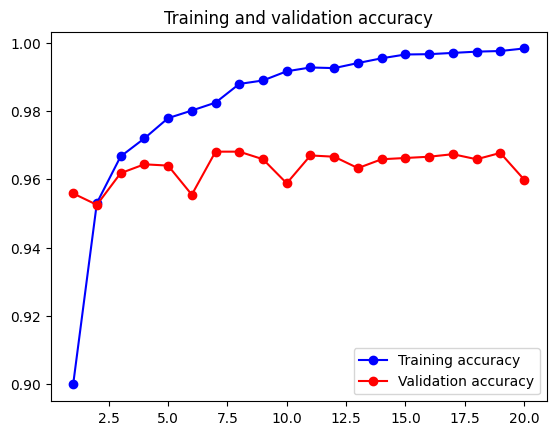

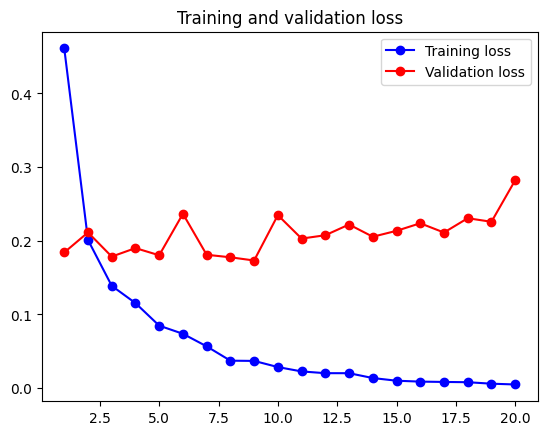

In [10]:
plot(history)

After seeing the results of the network, we see that a good result is obtained, exceeding 90% accuracy. We also see that this percentage is reached nearly to the end of the training, so the best option would be repeat the training with more epochs, but due to computation capacity, we don't have time to do that.

### Saving the results in a .csv

In [11]:
val_loss, val_acc = model.evaluate(val_dataset)

85/85 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9584 - loss: 0.3011


In [12]:
import os

def save_model_results(file_path, model_name, accuracy):
    """
    This function saves the model's accuracy to a CSV file. It checks if the file exists
    to add a header if necessary and then opens the file in append mode to add
    the model name and accuracy.
    """
    # Check if the file exists to decide on adding the header
    header_needed = not os.path.isfile(file_path)
    # Open the file in append mode, which creates the file if it doesn't exist
    with open(file_path, "a") as file:
        # Add a header if the file was just created
        if header_needed:
            file.write("model_name,accuracy\n")
        # Append the model name and accuracy to the file
        file.write(f"{model_name},{accuracy:.3f}\n")
    

In [13]:
save_model_results('val_results.csv', 'preTrained_FineTuning_InceptionV3', val_acc)
save_model_results('test_results.csv', 'preTrained_FineTuning_InceptionV3', test_acc)